In [ ]:
!pip -q install pytorch-tabnet

import pandas as pd
import numpy as np

from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [ ]:
DATASETS = {
    "Original":  "/content/OroginalDatasetBalanced.csv",          # label: Benign/Malicious
    "Mild":      "/content/Obfuscated_Mild.csv",       # label: 0/1
    "Moderate":  "/content/modarate_new.csv",     # label: 0/1
    "Strong":    "/content/Obfuscated_Strong.csv",       # label: 0/1
}

SEEDS = [42, 52, 62, 72, 82]
TEST_SIZE = 0.30

TABNET_PARAMS = dict(
    max_epochs=10,
    patience=10,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0
)


In [ ]:
def load_and_preprocess(csv_path, label_col="Label"):
    df = pd.read_csv(csv_path)
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in {csv_path}")

    # ---- Label handling (supports [0,1] or ['Benign','Malicious']) ----
    if df[label_col].dtype == object:
        df = df[df[label_col].isin(["Benign", "Malicious"])].copy()
        y = df[label_col].map({"Benign": 0, "Malicious": 1}).astype(int).to_numpy()
    else:
        df = df[df[label_col].isin([0, 1])].copy()
        y = df[label_col].astype(int).to_numpy()

    # ---- Numeric features only ----
    X = df.drop(columns=[label_col], errors="ignore").select_dtypes(include=[np.number]).copy()

    # Drop constant columns
    if len(X.columns) == 0:
        raise ValueError("No numeric features found after selecting numeric columns.")
    X = X.loc[:, (X != X.iloc[0]).any()]

    # Clean inf/nan
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)

    return X.to_numpy(), y, X.columns.tolist()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

VAL_SIZE = 0.20  # 20% of TRAIN used as validation

def train_eval_tabnet(X, y, seed=42):
    # 1) Train/Test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=seed
    )

    # 2) Train/Val split (from train only)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=VAL_SIZE, stratify=y_train_full, random_state=seed
    )

    # 3) Scale: fit on TRAIN only
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # 4) Train TabNet using VAL as eval_set (no test leakage)
    clf = TabNetClassifier(seed=seed)
    clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_name=["val"],
        eval_metric=["accuracy"],
        **TABNET_PARAMS
    )

    from sklearn.metrics import roc_auc_score, average_precision_score

    # 5) Final evaluation on TEST only
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # positive class probability

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_prob)
    pr  = average_precision_score(y_test, y_prob)
    cm  = confusion_matrix(y_test, y_pred)

    print("✅ Accuracy:", acc)
    print("✅ F1-macro:", f1)
    print("✅ ROC-AUC:", roc)
    print("✅ PR-AUC:", pr)
    print("✅ Confusion Matrix:\n", cm)
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    return acc, f1, roc, pr, cm





In [ ]:
results = []

for name, path in DATASETS.items():
    print("\n" + "="*80)
    print(f"DATASET: {name}")
    print(f"FILE: {path}")
    print("="*80)

    X, y, feats = load_and_preprocess(path)

    for seed in SEEDS:
        print(f"\n--- Seed {seed} ---")
        acc, f1, roc, pr, cm = train_eval_tabnet(X, y, seed=seed)
        results.append([name, seed, acc, f1, roc, pr])



summary = pd.DataFrame(
    results,
    columns=["Dataset", "Seed", "Accuracy", "F1_macro", "ROC_AUC", "PR_AUC"]
)

summary



DATASET: Original
FILE: /content/OroginalDatasetBalanced.csv

--- Seed 42 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56492 | val_accuracy: 0.82643 |  0:00:01s
epoch 1  | loss: 0.27631 | val_accuracy: 0.90286 |  0:00:02s
epoch 2  | loss: 0.20277 | val_accuracy: 0.94071 |  0:00:03s
epoch 3  | loss: 0.15406 | val_accuracy: 0.94071 |  0:00:04s
epoch 4  | loss: 0.1162  | val_accuracy: 0.95214 |  0:00:05s
epoch 5  | loss: 0.10919 | val_accuracy: 0.97143 |  0:00:06s
epoch 6  | loss: 0.11084 | val_accuracy: 0.97786 |  0:00:07s
epoch 7  | loss: 0.09537 | val_accuracy: 0.97571 |  0:00:09s
epoch 8  | loss: 0.08028 | val_accuracy: 0.97143 |  0:00:10s
epoch 9  | loss: 0.07261 | val_accuracy: 0.95929 |  0:00:11s
Stop training because you reached max_epochs = 10 with best_epoch = 6 and best_val_accuracy = 0.97786


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9786666666666667
✅ F1-macro: 0.9786665149618842
✅ ROC-AUC: 0.9957764444444445
✅ PR-AUC: 0.9953550393057788
✅ Confusion Matrix:
 [[1464   36]
 [  28 1472]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9812    0.9760    0.9786      1500
           1     0.9761    0.9813    0.9787      1500

    accuracy                         0.9787      3000
   macro avg     0.9787    0.9787    0.9787      3000
weighted avg     0.9787    0.9787    0.9787      3000


--- Seed 52 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5895  | val_accuracy: 0.76714 |  0:00:00s
epoch 1  | loss: 0.32703 | val_accuracy: 0.91071 |  0:00:00s
epoch 2  | loss: 0.22179 | val_accuracy: 0.94286 |  0:00:01s
epoch 3  | loss: 0.12366 | val_accuracy: 0.97143 |  0:00:01s
epoch 4  | loss: 0.11423 | val_accuracy: 0.97214 |  0:00:02s
epoch 5  | loss: 0.07975 | val_accuracy: 0.97786 |  0:00:02s
epoch 6  | loss: 0.07099 | val_accuracy: 0.95929 |  0:00:03s
epoch 7  | loss: 0.06708 | val_accuracy: 0.96143 |  0:00:03s
epoch 8  | loss: 0.07176 | val_accuracy: 0.96214 |  0:00:04s
epoch 9  | loss: 0.06086 | val_accuracy: 0.975   |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_accuracy = 0.97786


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.975
✅ F1-macro: 0.9749989971819981
✅ ROC-AUC: 0.994232
✅ PR-AUC: 0.9937555826637195
✅ Confusion Matrix:
 [[1453   47]
 [  28 1472]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9811    0.9687    0.9748      1500
           1     0.9691    0.9813    0.9752      1500

    accuracy                         0.9750      3000
   macro avg     0.9751    0.9750    0.9750      3000
weighted avg     0.9751    0.9750    0.9750      3000


--- Seed 62 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60508 | val_accuracy: 0.78786 |  0:00:00s
epoch 1  | loss: 0.41152 | val_accuracy: 0.86786 |  0:00:00s
epoch 2  | loss: 0.23448 | val_accuracy: 0.94286 |  0:00:01s
epoch 3  | loss: 0.16077 | val_accuracy: 0.95571 |  0:00:01s
epoch 4  | loss: 0.12694 | val_accuracy: 0.97357 |  0:00:02s
epoch 5  | loss: 0.11233 | val_accuracy: 0.96571 |  0:00:02s
epoch 6  | loss: 0.089   | val_accuracy: 0.97143 |  0:00:03s
epoch 7  | loss: 0.08688 | val_accuracy: 0.97857 |  0:00:04s
epoch 8  | loss: 0.08262 | val_accuracy: 0.97929 |  0:00:04s
epoch 9  | loss: 0.06862 | val_accuracy: 0.97071 |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_accuracy = 0.97929


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9746666666666667
✅ F1-macro: 0.9746617003599372
✅ ROC-AUC: 0.9953746666666665
✅ PR-AUC: 0.9959804725689481
✅ Confusion Matrix:
 [[1441   59]
 [  17 1483]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9883    0.9607    0.9743      1500
           1     0.9617    0.9887    0.9750      1500

    accuracy                         0.9747      3000
   macro avg     0.9750    0.9747    0.9747      3000
weighted avg     0.9750    0.9747    0.9747      3000


--- Seed 72 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68625 | val_accuracy: 0.82286 |  0:00:00s
epoch 1  | loss: 0.37892 | val_accuracy: 0.91714 |  0:00:00s
epoch 2  | loss: 0.21621 | val_accuracy: 0.94714 |  0:00:01s
epoch 3  | loss: 0.15335 | val_accuracy: 0.95786 |  0:00:01s
epoch 4  | loss: 0.12591 | val_accuracy: 0.96286 |  0:00:02s
epoch 5  | loss: 0.10969 | val_accuracy: 0.96714 |  0:00:02s
epoch 6  | loss: 0.10405 | val_accuracy: 0.95643 |  0:00:03s
epoch 7  | loss: 0.09724 | val_accuracy: 0.96143 |  0:00:03s
epoch 8  | loss: 0.09005 | val_accuracy: 0.95571 |  0:00:04s
epoch 9  | loss: 0.08375 | val_accuracy: 0.97071 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.97071


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9726666666666667
✅ F1-macro: 0.9726658891630695
✅ ROC-AUC: 0.9947857777777777
✅ PR-AUC: 0.9938948253517612
✅ Confusion Matrix:
 [[1451   49]
 [  33 1467]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9778    0.9673    0.9725      1500
           1     0.9677    0.9780    0.9728      1500

    accuracy                         0.9727      3000
   macro avg     0.9727    0.9727    0.9727      3000
weighted avg     0.9727    0.9727    0.9727      3000


--- Seed 82 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54656 | val_accuracy: 0.77214 |  0:00:00s
epoch 1  | loss: 0.2989  | val_accuracy: 0.87071 |  0:00:00s
epoch 2  | loss: 0.2006  | val_accuracy: 0.93429 |  0:00:01s
epoch 3  | loss: 0.13903 | val_accuracy: 0.95214 |  0:00:01s
epoch 4  | loss: 0.13155 | val_accuracy: 0.95357 |  0:00:02s
epoch 5  | loss: 0.0939  | val_accuracy: 0.98143 |  0:00:02s
epoch 6  | loss: 0.08773 | val_accuracy: 0.97786 |  0:00:03s
epoch 7  | loss: 0.07499 | val_accuracy: 0.97929 |  0:00:03s
epoch 8  | loss: 0.07347 | val_accuracy: 0.96286 |  0:00:03s
epoch 9  | loss: 0.08888 | val_accuracy: 0.97714 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_accuracy = 0.98143


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9773333333333334
✅ F1-macro: 0.9773326885742528
✅ ROC-AUC: 0.9947902222222222
✅ PR-AUC: 0.9902909399226308
✅ Confusion Matrix:
 [[1458   42]
 [  26 1474]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9825    0.9720    0.9772      1500
           1     0.9723    0.9827    0.9775      1500

    accuracy                         0.9773      3000
   macro avg     0.9774    0.9773    0.9773      3000
weighted avg     0.9774    0.9773    0.9773      3000


DATASET: Mild
FILE: /content/Obfuscated_Mild.csv

--- Seed 42 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64517 | val_accuracy: 0.77143 |  0:00:00s
epoch 1  | loss: 0.41001 | val_accuracy: 0.875   |  0:00:01s
epoch 2  | loss: 0.27245 | val_accuracy: 0.91857 |  0:00:01s
epoch 3  | loss: 0.20388 | val_accuracy: 0.93929 |  0:00:02s
epoch 4  | loss: 0.14999 | val_accuracy: 0.94929 |  0:00:02s
epoch 5  | loss: 0.14591 | val_accuracy: 0.96357 |  0:00:02s
epoch 6  | loss: 0.11724 | val_accuracy: 0.96429 |  0:00:03s
epoch 7  | loss: 0.09476 | val_accuracy: 0.95857 |  0:00:03s
epoch 8  | loss: 0.08064 | val_accuracy: 0.96929 |  0:00:04s
epoch 9  | loss: 0.07699 | val_accuracy: 0.97857 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.97857


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9733333333333334
✅ F1-macro: 0.9733325747932385
✅ ROC-AUC: 0.9974768888888889
✅ PR-AUC: 0.9968429946643129
✅ Confusion Matrix:
 [[1452   48]
 [  32 1468]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9784    0.9680    0.9732      1500
           1     0.9683    0.9787    0.9735      1500

    accuracy                         0.9733      3000
   macro avg     0.9734    0.9733    0.9733      3000
weighted avg     0.9734    0.9733    0.9733      3000


--- Seed 52 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6066  | val_accuracy: 0.75357 |  0:00:00s
epoch 1  | loss: 0.36305 | val_accuracy: 0.88429 |  0:00:00s
epoch 2  | loss: 0.25329 | val_accuracy: 0.94    |  0:00:01s
epoch 3  | loss: 0.21185 | val_accuracy: 0.93714 |  0:00:01s
epoch 4  | loss: 0.16211 | val_accuracy: 0.955   |  0:00:02s
epoch 5  | loss: 0.12762 | val_accuracy: 0.96071 |  0:00:02s
epoch 6  | loss: 0.12036 | val_accuracy: 0.96    |  0:00:03s
epoch 7  | loss: 0.10056 | val_accuracy: 0.97143 |  0:00:03s
epoch 8  | loss: 0.0876  | val_accuracy: 0.96643 |  0:00:03s
epoch 9  | loss: 0.08206 | val_accuracy: 0.96714 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_accuracy = 0.97143


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.964
✅ F1-macro: 0.9639992159829258
✅ ROC-AUC: 0.9927235555555556
✅ PR-AUC: 0.9911536430854552
✅ Confusion Matrix:
 [[1439   61]
 [  47 1453]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9684    0.9593    0.9638      1500
           1     0.9597    0.9687    0.9642      1500

    accuracy                         0.9640      3000
   macro avg     0.9640    0.9640    0.9640      3000
weighted avg     0.9640    0.9640    0.9640      3000


--- Seed 62 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6219  | val_accuracy: 0.78143 |  0:00:00s
epoch 1  | loss: 0.38636 | val_accuracy: 0.89214 |  0:00:00s
epoch 2  | loss: 0.23398 | val_accuracy: 0.91286 |  0:00:01s
epoch 3  | loss: 0.19478 | val_accuracy: 0.93786 |  0:00:02s
epoch 4  | loss: 0.14397 | val_accuracy: 0.95786 |  0:00:02s
epoch 5  | loss: 0.12584 | val_accuracy: 0.95571 |  0:00:03s
epoch 6  | loss: 0.10117 | val_accuracy: 0.96357 |  0:00:03s
epoch 7  | loss: 0.09764 | val_accuracy: 0.97357 |  0:00:04s
epoch 8  | loss: 0.09344 | val_accuracy: 0.97429 |  0:00:04s
epoch 9  | loss: 0.07935 | val_accuracy: 0.97071 |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_accuracy = 0.97429


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9693333333333334
✅ F1-macro: 0.9693324610122243
✅ ROC-AUC: 0.9942937777777778
✅ PR-AUC: 0.9925505427647007
✅ Confusion Matrix:
 [[1446   54]
 [  38 1462]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9744    0.9640    0.9692      1500
           1     0.9644    0.9747    0.9695      1500

    accuracy                         0.9693      3000
   macro avg     0.9694    0.9693    0.9693      3000
weighted avg     0.9694    0.9693    0.9693      3000


--- Seed 72 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72604 | val_accuracy: 0.69929 |  0:00:00s
epoch 1  | loss: 0.45998 | val_accuracy: 0.84071 |  0:00:00s
epoch 2  | loss: 0.28351 | val_accuracy: 0.90286 |  0:00:01s
epoch 3  | loss: 0.20099 | val_accuracy: 0.915   |  0:00:01s
epoch 4  | loss: 0.17913 | val_accuracy: 0.93286 |  0:00:02s
epoch 5  | loss: 0.14585 | val_accuracy: 0.94429 |  0:00:02s
epoch 6  | loss: 0.12795 | val_accuracy: 0.96643 |  0:00:03s
epoch 7  | loss: 0.11148 | val_accuracy: 0.95214 |  0:00:03s
epoch 8  | loss: 0.09477 | val_accuracy: 0.96286 |  0:00:04s
epoch 9  | loss: 0.08331 | val_accuracy: 0.97429 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.97429


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9733333333333334
✅ F1-macro: 0.9733313302199142
✅ ROC-AUC: 0.9946862222222222
✅ PR-AUC: 0.9939229929607002
✅ Confusion Matrix:
 [[1447   53]
 [  27 1473]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9817    0.9647    0.9731      1500
           1     0.9653    0.9820    0.9736      1500

    accuracy                         0.9733      3000
   macro avg     0.9735    0.9733    0.9733      3000
weighted avg     0.9735    0.9733    0.9733      3000


--- Seed 82 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58082 | val_accuracy: 0.78143 |  0:00:00s
epoch 1  | loss: 0.33686 | val_accuracy: 0.86429 |  0:00:00s
epoch 2  | loss: 0.25152 | val_accuracy: 0.92857 |  0:00:01s
epoch 3  | loss: 0.20764 | val_accuracy: 0.94071 |  0:00:01s
epoch 4  | loss: 0.17876 | val_accuracy: 0.95786 |  0:00:02s
epoch 5  | loss: 0.13553 | val_accuracy: 0.965   |  0:00:02s
epoch 6  | loss: 0.12774 | val_accuracy: 0.95429 |  0:00:03s
epoch 7  | loss: 0.10898 | val_accuracy: 0.96714 |  0:00:03s
epoch 8  | loss: 0.11974 | val_accuracy: 0.97    |  0:00:04s
epoch 9  | loss: 0.09725 | val_accuracy: 0.96429 |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_accuracy = 0.97


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9676666666666667
✅ F1-macro: 0.9676587286812952
✅ ROC-AUC: 0.9937382222222221
✅ PR-AUC: 0.989356260836463
✅ Confusion Matrix:
 [[1428   72]
 [  25 1475]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9828    0.9520    0.9672      1500
           1     0.9535    0.9833    0.9682      1500

    accuracy                         0.9677      3000
   macro avg     0.9681    0.9677    0.9677      3000
weighted avg     0.9681    0.9677    0.9677      3000


DATASET: Moderate
FILE: /content/modarate_new.csv

--- Seed 42 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76373 | val_accuracy: 0.69214 |  0:00:00s
epoch 1  | loss: 0.60087 | val_accuracy: 0.74143 |  0:00:00s
epoch 2  | loss: 0.53306 | val_accuracy: 0.74857 |  0:00:01s
epoch 3  | loss: 0.48355 | val_accuracy: 0.76714 |  0:00:01s
epoch 4  | loss: 0.42012 | val_accuracy: 0.80286 |  0:00:02s
epoch 5  | loss: 0.38784 | val_accuracy: 0.82214 |  0:00:02s
epoch 6  | loss: 0.365   | val_accuracy: 0.85571 |  0:00:03s
epoch 7  | loss: 0.32477 | val_accuracy: 0.88143 |  0:00:03s
epoch 8  | loss: 0.28602 | val_accuracy: 0.89857 |  0:00:04s
epoch 9  | loss: 0.27019 | val_accuracy: 0.90571 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.90571


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.8926666666666667
✅ F1-macro: 0.8923370265671204
✅ ROC-AUC: 0.9556231111111111
✅ PR-AUC: 0.9459126366769925
✅ Confusion Matrix:
 [[1256  244]
 [  78 1422]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9415    0.8373    0.8864      1500
           1     0.8535    0.9480    0.8983      1500

    accuracy                         0.8927      3000
   macro avg     0.8975    0.8927    0.8923      3000
weighted avg     0.8975    0.8927    0.8923      3000


--- Seed 52 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67406 | val_accuracy: 0.66786 |  0:00:00s
epoch 1  | loss: 0.52101 | val_accuracy: 0.76929 |  0:00:00s
epoch 2  | loss: 0.42599 | val_accuracy: 0.81    |  0:00:01s
epoch 3  | loss: 0.39834 | val_accuracy: 0.83357 |  0:00:01s
epoch 4  | loss: 0.37441 | val_accuracy: 0.83857 |  0:00:02s
epoch 5  | loss: 0.33387 | val_accuracy: 0.87143 |  0:00:02s
epoch 6  | loss: 0.31302 | val_accuracy: 0.89143 |  0:00:03s
epoch 7  | loss: 0.27958 | val_accuracy: 0.88714 |  0:00:03s
epoch 8  | loss: 0.27047 | val_accuracy: 0.895   |  0:00:04s
epoch 9  | loss: 0.24894 | val_accuracy: 0.90643 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.90643


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.8933333333333333
✅ F1-macro: 0.893120096049407
✅ ROC-AUC: 0.9478566666666667
✅ PR-AUC: 0.9358074149140929
✅ Confusion Matrix:
 [[1273  227]
 [  93 1407]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9319    0.8487    0.8883      1500
           1     0.8611    0.9380    0.8979      1500

    accuracy                         0.8933      3000
   macro avg     0.8965    0.8933    0.8931      3000
weighted avg     0.8965    0.8933    0.8931      3000


--- Seed 62 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72094 | val_accuracy: 0.64357 |  0:00:00s
epoch 1  | loss: 0.55789 | val_accuracy: 0.71286 |  0:00:01s
epoch 2  | loss: 0.50171 | val_accuracy: 0.75571 |  0:00:01s
epoch 3  | loss: 0.45407 | val_accuracy: 0.79571 |  0:00:02s
epoch 4  | loss: 0.43009 | val_accuracy: 0.80571 |  0:00:02s
epoch 5  | loss: 0.39554 | val_accuracy: 0.83286 |  0:00:03s
epoch 6  | loss: 0.36059 | val_accuracy: 0.85714 |  0:00:03s
epoch 7  | loss: 0.33924 | val_accuracy: 0.87143 |  0:00:04s
epoch 8  | loss: 0.29537 | val_accuracy: 0.86929 |  0:00:04s
epoch 9  | loss: 0.26767 | val_accuracy: 0.87143 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_accuracy = 0.87143


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.8636666666666667
✅ F1-macro: 0.8636139155600071
✅ ROC-AUC: 0.9253684444444444
✅ PR-AUC: 0.9024268862942574
✅ Confusion Matrix:
 [[1266  234]
 [ 175 1325]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.8786    0.8440    0.8609      1500
           1     0.8499    0.8833    0.8663      1500

    accuracy                         0.8637      3000
   macro avg     0.8642    0.8637    0.8636      3000
weighted avg     0.8642    0.8637    0.8636      3000


--- Seed 72 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84241 | val_accuracy: 0.58429 |  0:00:00s
epoch 1  | loss: 0.57651 | val_accuracy: 0.73429 |  0:00:00s
epoch 2  | loss: 0.47962 | val_accuracy: 0.79786 |  0:00:01s
epoch 3  | loss: 0.40376 | val_accuracy: 0.81786 |  0:00:01s
epoch 4  | loss: 0.36186 | val_accuracy: 0.83643 |  0:00:02s
epoch 5  | loss: 0.32343 | val_accuracy: 0.87286 |  0:00:02s
epoch 6  | loss: 0.28098 | val_accuracy: 0.88214 |  0:00:03s
epoch 7  | loss: 0.25307 | val_accuracy: 0.87786 |  0:00:03s
epoch 8  | loss: 0.2312  | val_accuracy: 0.88857 |  0:00:04s
epoch 9  | loss: 0.21969 | val_accuracy: 0.91429 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.91429


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9213333333333333
✅ F1-macro: 0.9212686336460496
✅ ROC-AUC: 0.9707393333333334
✅ PR-AUC: 0.9629108149461423
✅ Confusion Matrix:
 [[1339  161]
 [  75 1425]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9470    0.8927    0.9190      1500
           1     0.8985    0.9500    0.9235      1500

    accuracy                         0.9213      3000
   macro avg     0.9227    0.9213    0.9213      3000
weighted avg     0.9227    0.9213    0.9213      3000


--- Seed 82 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79291 | val_accuracy: 0.65214 |  0:00:00s
epoch 1  | loss: 0.52535 | val_accuracy: 0.80286 |  0:00:00s
epoch 2  | loss: 0.4413  | val_accuracy: 0.81357 |  0:00:01s
epoch 3  | loss: 0.39763 | val_accuracy: 0.84786 |  0:00:02s
epoch 4  | loss: 0.35884 | val_accuracy: 0.85571 |  0:00:02s
epoch 5  | loss: 0.3316  | val_accuracy: 0.87214 |  0:00:03s
epoch 6  | loss: 0.2941  | val_accuracy: 0.88929 |  0:00:04s
epoch 7  | loss: 0.27421 | val_accuracy: 0.90214 |  0:00:04s
epoch 8  | loss: 0.25065 | val_accuracy: 0.90857 |  0:00:04s
epoch 9  | loss: 0.2312  | val_accuracy: 0.92    |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_accuracy = 0.92


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.9153333333333333
✅ F1-macro: 0.9152730830813023
✅ ROC-AUC: 0.9621142222222222
✅ PR-AUC: 0.9484298903055659
✅ Confusion Matrix:
 [[1333  167]
 [  87 1413]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.9387    0.8887    0.9130      1500
           1     0.8943    0.9420    0.9175      1500

    accuracy                         0.9153      3000
   macro avg     0.9165    0.9153    0.9153      3000
weighted avg     0.9165    0.9153    0.9153      3000


DATASET: Strong
FILE: /content/Obfuscated_Strong.csv

--- Seed 42 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78124 | val_accuracy: 0.50357 |  0:00:00s
epoch 1  | loss: 0.70458 | val_accuracy: 0.50286 |  0:00:00s
epoch 2  | loss: 0.69538 | val_accuracy: 0.49857 |  0:00:01s
epoch 3  | loss: 0.69386 | val_accuracy: 0.52071 |  0:00:01s
epoch 4  | loss: 0.69262 | val_accuracy: 0.495   |  0:00:02s
epoch 5  | loss: 0.69158 | val_accuracy: 0.50357 |  0:00:02s
epoch 6  | loss: 0.69149 | val_accuracy: 0.50571 |  0:00:03s
epoch 7  | loss: 0.69032 | val_accuracy: 0.49429 |  0:00:03s
epoch 8  | loss: 0.68877 | val_accuracy: 0.485   |  0:00:04s
epoch 9  | loss: 0.69032 | val_accuracy: 0.46071 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 3 and best_val_accuracy = 0.52071


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.49266666666666664
✅ F1-macro: 0.4886465192349991
✅ ROC-AUC: 0.49565911111111105
✅ PR-AUC: 0.49967533223809757
✅ Confusion Matrix:
 [[606 894]
 [628 872]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.4911    0.4040    0.4433      1500
           1     0.4938    0.5813    0.5340      1500

    accuracy                         0.4927      3000
   macro avg     0.4924    0.4927    0.4886      3000
weighted avg     0.4924    0.4927    0.4886      3000


--- Seed 52 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84951 | val_accuracy: 0.48643 |  0:00:00s
epoch 1  | loss: 0.70638 | val_accuracy: 0.485   |  0:00:01s
epoch 2  | loss: 0.69491 | val_accuracy: 0.51714 |  0:00:02s
epoch 3  | loss: 0.69234 | val_accuracy: 0.53214 |  0:00:04s
epoch 4  | loss: 0.69423 | val_accuracy: 0.54714 |  0:00:05s
epoch 5  | loss: 0.69395 | val_accuracy: 0.53    |  0:00:05s
epoch 6  | loss: 0.69207 | val_accuracy: 0.54286 |  0:00:06s
epoch 7  | loss: 0.69119 | val_accuracy: 0.54857 |  0:00:06s
epoch 8  | loss: 0.6901  | val_accuracy: 0.53071 |  0:00:07s
epoch 9  | loss: 0.68984 | val_accuracy: 0.51214 |  0:00:07s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_accuracy = 0.54857


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.5026666666666667
✅ F1-macro: 0.4949848247227268
✅ ROC-AUC: 0.5041691111111111
✅ PR-AUC: 0.4997252665065246
✅ Confusion Matrix:
 [[569 931]
 [561 939]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.5035    0.3793    0.4327      1500
           1     0.5021    0.6260    0.5573      1500

    accuracy                         0.5027      3000
   macro avg     0.5028    0.5027    0.4950      3000
weighted avg     0.5028    0.5027    0.4950      3000


--- Seed 62 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78512 | val_accuracy: 0.50571 |  0:00:00s
epoch 1  | loss: 0.70626 | val_accuracy: 0.50286 |  0:00:00s
epoch 2  | loss: 0.69549 | val_accuracy: 0.50786 |  0:00:01s
epoch 3  | loss: 0.69372 | val_accuracy: 0.49214 |  0:00:01s
epoch 4  | loss: 0.69249 | val_accuracy: 0.48    |  0:00:02s
epoch 5  | loss: 0.69213 | val_accuracy: 0.48429 |  0:00:02s
epoch 6  | loss: 0.69153 | val_accuracy: 0.48857 |  0:00:03s
epoch 7  | loss: 0.69053 | val_accuracy: 0.5     |  0:00:03s
epoch 8  | loss: 0.69046 | val_accuracy: 0.495   |  0:00:04s
epoch 9  | loss: 0.69013 | val_accuracy: 0.50214 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 2 and best_val_accuracy = 0.50786


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.5073333333333333
✅ F1-macro: 0.504420426730449
✅ ROC-AUC: 0.5098446666666666
✅ PR-AUC: 0.5091966347726138
✅ Confusion Matrix:
 [[646 854]
 [624 876]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.5087    0.4307    0.4664      1500
           1     0.5064    0.5840    0.5424      1500

    accuracy                         0.5073      3000
   macro avg     0.5075    0.5073    0.5044      3000
weighted avg     0.5075    0.5073    0.5044      3000


--- Seed 72 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86796 | val_accuracy: 0.48571 |  0:00:00s
epoch 1  | loss: 0.7196  | val_accuracy: 0.48    |  0:00:00s
epoch 2  | loss: 0.70395 | val_accuracy: 0.50643 |  0:00:01s
epoch 3  | loss: 0.69538 | val_accuracy: 0.49857 |  0:00:01s
epoch 4  | loss: 0.69538 | val_accuracy: 0.53286 |  0:00:02s
epoch 5  | loss: 0.69256 | val_accuracy: 0.48786 |  0:00:03s
epoch 6  | loss: 0.6928  | val_accuracy: 0.48786 |  0:00:03s
epoch 7  | loss: 0.69166 | val_accuracy: 0.49643 |  0:00:04s
epoch 8  | loss: 0.69212 | val_accuracy: 0.50929 |  0:00:04s
epoch 9  | loss: 0.69176 | val_accuracy: 0.51357 |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 4 and best_val_accuracy = 0.53286


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.5126666666666667
✅ F1-macro: 0.5111335815784969
✅ ROC-AUC: 0.516204
✅ PR-AUC: 0.5086008888584179
✅ Confusion Matrix:
 [[853 647]
 [815 685]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.5114    0.5687    0.5385      1500
           1     0.5143    0.4567    0.4838      1500

    accuracy                         0.5127      3000
   macro avg     0.5128    0.5127    0.5111      3000
weighted avg     0.5128    0.5127    0.5111      3000


--- Seed 82 ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79756 | val_accuracy: 0.49929 |  0:00:00s
epoch 1  | loss: 0.70798 | val_accuracy: 0.50214 |  0:00:00s
epoch 2  | loss: 0.69825 | val_accuracy: 0.51143 |  0:00:01s
epoch 3  | loss: 0.6961  | val_accuracy: 0.50357 |  0:00:01s
epoch 4  | loss: 0.69482 | val_accuracy: 0.49857 |  0:00:02s
epoch 5  | loss: 0.69148 | val_accuracy: 0.51143 |  0:00:02s
epoch 6  | loss: 0.69239 | val_accuracy: 0.50929 |  0:00:03s
epoch 7  | loss: 0.69074 | val_accuracy: 0.49643 |  0:00:03s
epoch 8  | loss: 0.69148 | val_accuracy: 0.50143 |  0:00:04s
epoch 9  | loss: 0.68946 | val_accuracy: 0.50214 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 2 and best_val_accuracy = 0.51143


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ Accuracy: 0.5073333333333333
✅ F1-macro: 0.49536541962516367
✅ ROC-AUC: 0.5146786666666667
✅ PR-AUC: 0.5183201328146256
✅ Confusion Matrix:
 [[530 970]
 [508 992]]

✅ Classification Report:
               precision    recall  f1-score   support

           0     0.5106    0.3533    0.4177      1500
           1     0.5056    0.6613    0.5731      1500

    accuracy                         0.5073      3000
   macro avg     0.5081    0.5073    0.4954      3000
weighted avg     0.5081    0.5073    0.4954      3000



,Dataset,Seed,Accuracy,F1_macro,ROC_AUC,PR_AUC
0,Original,42,0.978667,0.978667,0.995776,0.995355
1,Original,52,0.975000,0.974999,0.994232,0.993756
2,Original,62,0.974667,0.974662,0.995375,0.995980
3,Original,72,0.972667,0.972666,0.994786,0.993895
4,Original,82,0.977333,0.977333,0.994790,0.990291
5,Mild,42,0.973333,0.973333,0.997477,0.996843
6,Mild,52,0.964000,0.963999,0.992724,0.991154
7,Mild,62,0.969333,0.969332,0.994294,0.992551
8,Mild,72,0.973333,0.973331,0.994686,0.993923
9,Mild,82,0.967667,0.967659,0.993738,0.989356


In [ ]:
import numpy as np
from scipy import stats

def mean_std_ci(x, confidence=0.95):
    x = np.array(x)
    mean = x.mean()
    std  = x.std(ddof=1)
    n    = len(x)
    h    = stats.t.ppf((1 + confidence) / 2., n-1) * std / np.sqrt(n)
    return mean, std, h

agg_rows = []

for dataset in summary["Dataset"].unique():
    df_d = summary[summary["Dataset"] == dataset]

    acc_mean, acc_std, acc_ci = mean_std_ci(df_d["Accuracy"])
    f1_mean,  f1_std,  f1_ci  = mean_std_ci(df_d["F1_macro"])
    roc_mean, roc_std, roc_ci = mean_std_ci(df_d["ROC_AUC"])
    pr_mean,  pr_std,  pr_ci  = mean_std_ci(df_d["PR_AUC"])

    agg_rows.append([
        dataset,
        acc_mean, acc_std, acc_ci,
        f1_mean,  f1_std,  f1_ci,
        roc_mean, roc_std, roc_ci,
        pr_mean,  pr_std,  pr_ci
    ])

agg = pd.DataFrame(
    agg_rows,
    columns=[
        "Dataset",
        "Accuracy_mean", "Accuracy_std", "Accuracy_95CI",
        "F1_macro_mean", "F1_macro_std", "F1_macro_95CI",
        "ROC_AUC_mean", "ROC_AUC_std", "ROC_AUC_95CI",
        "PR_AUC_mean",  "PR_AUC_std",  "PR_AUC_95CI"
    ]
)

agg


,Dataset,Accuracy_mean,Accuracy_std,Accuracy_95CI,F1_macro_mean,F1_macro_std,F1_macro_95CI,ROC_AUC_mean,ROC_AUC_std,ROC_AUC_95CI,PR_AUC_mean,PR_AUC_std,PR_AUC_95CI
0,Original,0.975667,0.002357,0.002927,0.975665,0.002358,0.002927,0.994992,0.000596,0.000740,0.993855,0.002207,0.002740
1,Mild,0.969533,0.003969,0.004929,0.969531,0.003970,0.004929,0.994584,0.001778,0.002207,0.992765,0.002839,0.003525
2,Moderate,0.897267,0.022755,0.028254,0.897123,0.022772,0.028275,0.952340,0.017266,0.021438,0.939098,0.022673,0.028152
3,Strong,0.504533,0.007519,0.009336,0.498910,0.008847,0.010985,0.508111,0.008400,0.010430,0.507104,0.007779,0.009659


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def run_and_plot_cm(csv_path, seed, title):
    # Load
    X, y, _ = load_and_preprocess(csv_path)

    # Train / Test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=seed
    )

    # Train / Val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=seed
    )

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Train model
    clf = TabNetClassifier(seed=seed)
    clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["accuracy"],
        **TABNET_PARAMS
    )

    # Predict
    y_pred = clf.predict(X_test)

    # Confusion matrix (RAW COUNTS)
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Benign", "Malicious"],
        yticklabels=["Benign", "Malicious"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67406 | val_0_accuracy: 0.66786 |  0:00:00s
epoch 1  | loss: 0.52101 | val_0_accuracy: 0.76929 |  0:00:00s
epoch 2  | loss: 0.42599 | val_0_accuracy: 0.81    |  0:00:01s
epoch 3  | loss: 0.39834 | val_0_accuracy: 0.83357 |  0:00:01s
epoch 4  | loss: 0.37441 | val_0_accuracy: 0.83857 |  0:00:02s
epoch 5  | loss: 0.33387 | val_0_accuracy: 0.87143 |  0:00:02s
epoch 6  | loss: 0.31302 | val_0_accuracy: 0.89143 |  0:00:03s
epoch 7  | loss: 0.27958 | val_0_accuracy: 0.88714 |  0:00:04s
epoch 8  | loss: 0.27047 | val_0_accuracy: 0.895   |  0:00:04s
epoch 9  | loss: 0.24894 | val_0_accuracy: 0.90643 |  0:00:05s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_accuracy = 0.90643


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


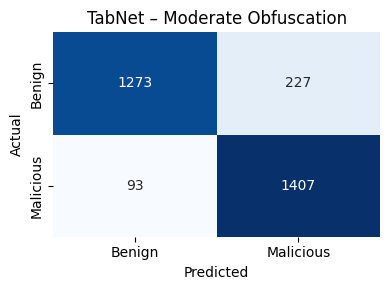

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84951 | val_0_accuracy: 0.48643 |  0:00:00s
epoch 1  | loss: 0.70638 | val_0_accuracy: 0.485   |  0:00:00s
epoch 2  | loss: 0.69491 | val_0_accuracy: 0.51714 |  0:00:01s
epoch 3  | loss: 0.69234 | val_0_accuracy: 0.53214 |  0:00:01s
epoch 4  | loss: 0.69423 | val_0_accuracy: 0.54714 |  0:00:02s
epoch 5  | loss: 0.69395 | val_0_accuracy: 0.53    |  0:00:02s
epoch 6  | loss: 0.69207 | val_0_accuracy: 0.54286 |  0:00:03s
epoch 7  | loss: 0.69119 | val_0_accuracy: 0.54857 |  0:00:03s
epoch 8  | loss: 0.6901  | val_0_accuracy: 0.53071 |  0:00:04s
epoch 9  | loss: 0.68984 | val_0_accuracy: 0.51214 |  0:00:04s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_0_accuracy = 0.54857


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


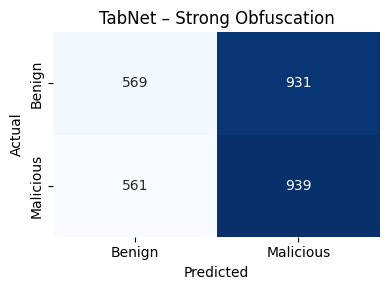

In [ ]:
# Moderate (representative seed)
run_and_plot_cm(
    DATASETS["Moderate"],
    seed=52,
    title="TabNet – Moderate Obfuscation"
)

# Strong (representative seed)
run_and_plot_cm(
    DATASETS["Strong"],
    seed=52,
    title="TabNet – Strong Obfuscation"
)


Modearte new

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
# === Obfuscate and Save Dataset ===

###########################################################################Obfuscated_Moderate.csv#############################################################


import pandas as pd
import numpy as np
import hashlib

# === Load Data ===
df = pd.read_csv("/content/OroginalDatasetBalanced.csv")

# === Strong Hash Obfuscation (IP fields only) ===
# === Strong Hash Obfuscation ===
for col in ['Source IP', 'Destination IP', 'Flow ID']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())

# === Encode Labels ===
df['Label'] = df['Label'].map({'Benign': 0, 'Malicious': 1})
df.dropna(subset=['Label'], inplace=True)


# === Identify numeric features EXCLUDING the Label column
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Label')

# === Add Gaussian Noise to Numeric Features ===

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Label')

for col in numeric_cols:
    std = df[col].std()
    noise = np.random.normal(0, 0.35 * std, size=len(df))
    df[col] += noise
    df[col] = df[col].clip(lower=0)
# ❌ REMOVE Permutation – shuffling removes feature identity

# === Binning (Discretization to 5 quantile bins) ===
for col in numeric_cols:
    try:
        df[col] = pd.qcut(df[col], q=5, labels=False, duplicates='drop')
    except:
        pass

# === Reduce Random Masking to 10% ===
mask_prob = 0.2
for col in numeric_cols:
    mask = np.random.rand(len(df)) < mask_prob
    df.loc[mask, col] = 0

# === Save the obfuscated dataset ===
df.to_csv("modarate_new.csv", index=False)
print("✅ Obfuscated dataset saved as 'NEWobfuscatedModerate.csv'")

✅ Obfuscated dataset saved as 'NEWobfuscatedModerate.csv'
